In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
# load dataset
df = pd.read_csv('../files/phd_field.csv', encoding='latin-1')
print(df.columns)
df.head()

Index(['genotype', 'rep', 'block', 'sowing_date', 'pigmentation',
       'growth_habit', 'tendril', 'pubescence', 'flower_color', 'coat_color',
       'coat_patern', 'cotyledon_color', 'flowering_date', 'days_flowering',
       'crop_date', 'days_crop', 'plant_height', 'seeds_pod', 'pods_plant',
       'seeds_plant', 'seed_diameter', 'weight_100_seeds', 'plants_plot',
       'yield', 'protein', 'phytic_acid', 'phenols', 'tanins'],
      dtype='object')


,genotype,rep,block,sowing_date,pigmentation,growth_habit,tendril,pubescence,flower_color,coat_color,...,pods_plant,seeds_plant,seed_diameter,weight_100_seeds,plants_plot,yield,protein,phytic_acid,phenols,tanins
0,1r,1,1,7/2/2020,0,1,1,1,2,2,...,16,26,2.5,2.1,10,5.4,13.7,1.2,0.65,0.44
1,1r,2,2,7/2/2020,0,1,1,1,2,2,...,14,26,2.6,2.5,10,6.4,15.4,1.1,0.75,0.49
2,1r,1,1,7/12/2021,0,1,1,1,2,2,...,21,36,2.6,2.5,10,8.9,26.2,1.0,0.43,0.30
3,1r,2,2,7/12/2021,0,1,1,1,2,2,...,15,25,2.5,2.2,10,5.6,25.0,1.2,0.40,0.26
4,10r,1,1,7/2/2020,0,1,1,1,2,2,...,7,14,3.4,3.2,10,4.4,12.9,1.1,0.52,0.37


In [5]:
# checking missing values
df.isna().sum().sum()

0

In [3]:
# transforming sowing_date in datetime object
df['sowing_date'] = pd.to_datetime(df['sowing_date'], format='%d/%m/%Y')

# spliting date info
df['sowing_year'] = df['sowing_date'].dt.year

In [11]:
# features
categorical_features = ['pigmentation', 'growth_habit', 'tendril', 'pubescence', 'flower_color', 'coat_color', 'coat_patern', 'cotyledon_color']

agronomic_features = ['days_flowering', 'days_crop', 'plant_height', 'seeds_pod', 'pods_plant', 'seeds_plant', 'seed_diameter', 'weight_100_seeds']
quality_features = ['protein', 'phytic_acid', 'phenols', 'tanins']

numerical_features = agronomic_features + quality_features

In [7]:
# mapping categorical_features
df['pigmentation'] = df['pigmentation'].map({0: 'absence', 1: 'low', 2: 'high'})
df['growth_habit'] = df['growth_habit'].map({0: 'horizontal', 1: 'inclined', 2: 'vertical'})
df['tendril'] = df['tendril'].map({0: 'absence', 1: 'low', 2: 'high'})
df['pubescence'] = df['pubescence'].map({0: 'absence', 1: 'presence'})
df['flower_color'] = df['flower_color'].map({2: 'white_violet', 3: 'violet'})
df['coat_color'] = df['coat_color'].map({2: 'brown', 3: 'grey', 4: 'green'})
df['coat_patern'] = df['coat_patern'].map({1: 'absence', 2: 'spotted', 3: 'dotted', 4: 'complex'})
df['cotyledon_color'] = df['cotyledon_color'].map({1: 'yellow', 2: 'orange', 3: 'green'})

In [8]:
df.head()

,genotype,rep,block,sowing_date,pigmentation,growth_habit,tendril,pubescence,flower_color,coat_color,...,seeds_plant,seed_diameter,weight_100_seeds,plants_plot,yield,protein,phytic_acid,phenols,tanins,sowing_year
0,1r,1,1,2020-02-07,absence,inclined,low,presence,white_violet,brown,...,26,2.5,2.1,10,5.4,13.7,1.2,0.65,0.44,2020
1,1r,2,2,2020-02-07,absence,inclined,low,presence,white_violet,brown,...,26,2.6,2.5,10,6.4,15.4,1.1,0.75,0.49,2020
2,1r,1,1,2021-12-07,absence,inclined,low,presence,white_violet,brown,...,36,2.6,2.5,10,8.9,26.2,1.0,0.43,0.30,2021
3,1r,2,2,2021-12-07,absence,inclined,low,presence,white_violet,brown,...,25,2.5,2.2,10,5.6,25.0,1.2,0.40,0.26,2021
4,10r,1,1,2020-02-07,absence,inclined,low,presence,white_violet,brown,...,14,3.4,3.2,10,4.4,12.9,1.1,0.52,0.37,2020


# checking categorical_features

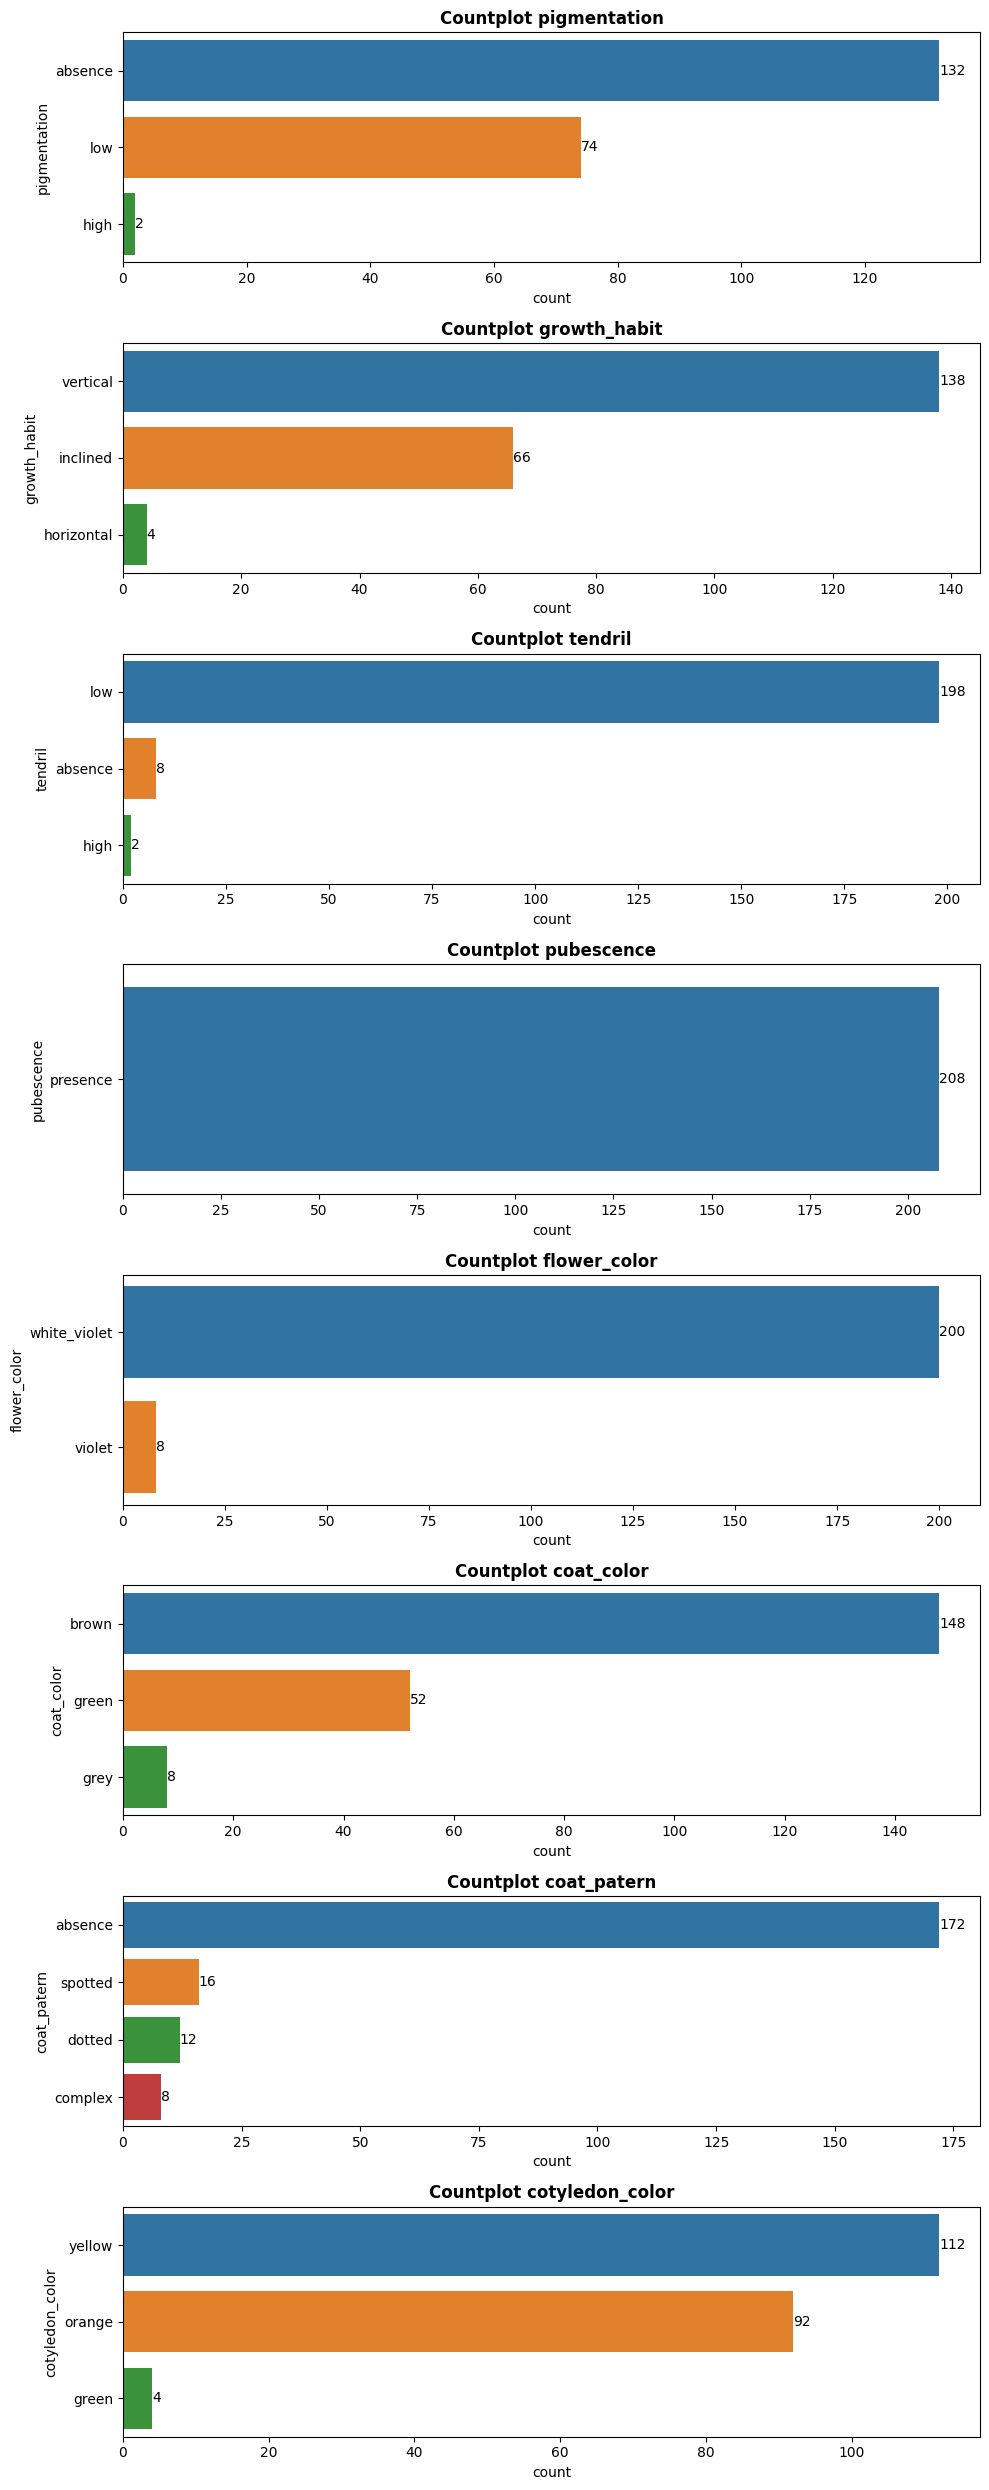

In [9]:
fig, ax = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(10, 25))
for i, feature in enumerate(categorical_features):
    ax[i] = sns.countplot(y=df[feature], ax=ax[i], order=df[feature].value_counts().index)
    ax[i].set_title(f'Countplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})
    for container in ax[i].containers:
        ax[i].bar_label(container)
plt.tight_layout()
plt.show()

# checking numerical_features

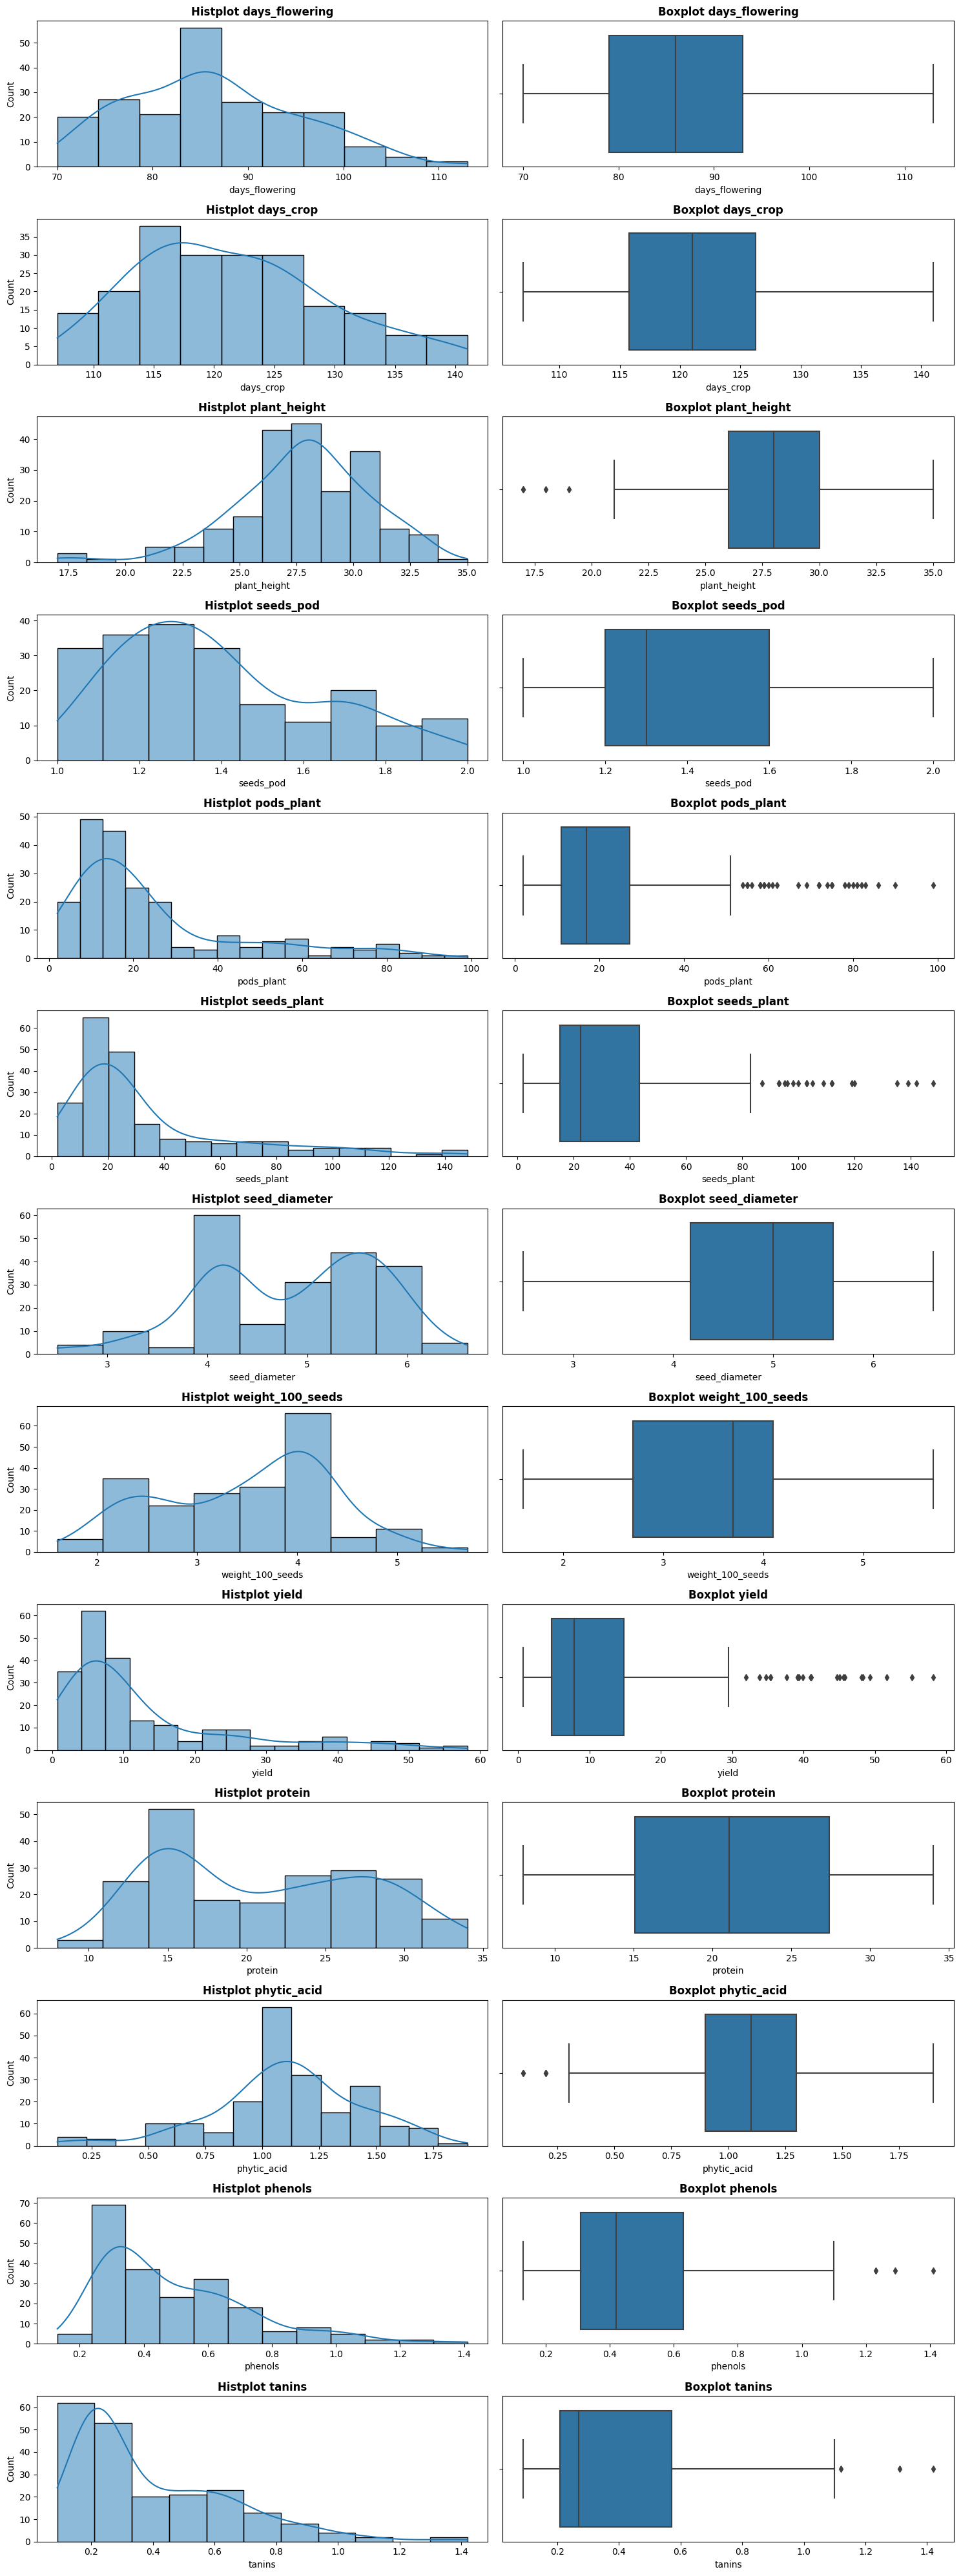

In [10]:
fig, ax = plt.subplots(nrows=len(numerical_features), ncols=2, figsize=(15, 40))
for i, feature in enumerate(numerical_features):
    ax[i][0] = sns.histplot(x=df[feature], ax=ax[i][0], kde=True)
    ax[i][0].set_title(f'Histplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})
    ax[i][1] = sns.boxplot(x=df[feature], ax=ax[i][1])
    ax[i][1].set_title(f'Boxplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})

plt.tight_layout()
plt.show()

# phenotipic correlations

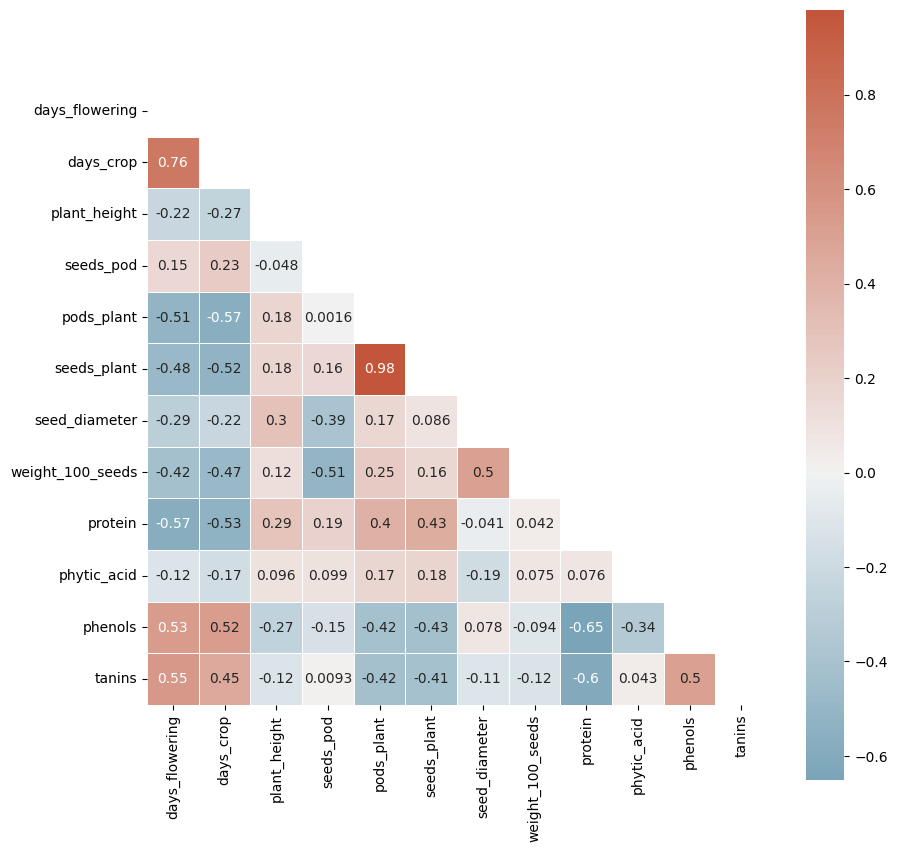

In [238]:
mask = np.triu(np.ones_like(df[numerical_features].corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df[numerical_features].corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

# ANOVAs

In [60]:
# agronomic_features
for feature in agronomic_features:
    model = ols(formula = f'{feature} ~ genotype + sowing_year + genotype:sowing_year',
                data=df).fit()
    anova_results = sm.stats.anova_lm(model, test='F', type=2)
    print(f'ANOVA for {feature}:')
    print(anova_results)
    print()

ANOVA for days_flowering:
                         df       sum_sq      mean_sq             F  \
genotype               51.0  8544.745192   167.544023    345.041157   
sowing_year             1.0  7238.120192  7238.120192  14906.227723   
genotype:sowing_year   51.0  1363.129808    26.728035     55.043875   
Residual              104.0    50.500000     0.485577           NaN   

                             PR(>F)  
genotype               5.623714e-97  
sowing_year           4.050006e-114  
genotype:sowing_year   1.570146e-56  
Residual                        NaN  

ANOVA for days_crop:
                         df        sum_sq       mean_sq             F  PR(>F)
genotype               51.0  7.261923e+03  1.423906e+02  9.806596e+16     0.0
sowing_year             1.0  5.001923e+03  5.001923e+03  3.444878e+18     0.0
genotype:sowing_year   51.0  8.520769e+02  1.670739e+01  1.150656e+16     0.0
Residual              104.0  1.510068e-13  1.451988e-15           NaN     NaN

ANOVA for plant

In [101]:
# quality_features
for feature in quality_features:
    model = ols(formula = f'{feature} ~ genotype + sowing_year + genotype:sowing_year',
                data=df).fit()
    anova_results = sm.stats.anova_lm(model, test='F', type=2)
    print(f'ANOVA for {feature}:')
    print(anova_results)
    print()

ANOVA for protein:
                         df       sum_sq      mean_sq            F  \
genotype               51.0   930.200144    18.239219     5.426243   
sowing_year             1.0  6575.626202  6575.626202  1956.275835   
genotype:sowing_year   51.0  1118.696298    21.935222     6.525819   
Residual              104.0   349.575000     3.361298          NaN   

                            PR(>F)  
genotype              1.592566e-13  
sowing_year           2.917588e-69  
genotype:sowing_year  3.852372e-16  
Residual                       NaN  

ANOVA for phytic_acid:
                         df     sum_sq   mean_sq          F        PR(>F)
genotype               51.0  13.135144  0.257552  19.339633  5.125240e-35
sowing_year             1.0   0.490433  0.490433  36.826715  2.122529e-08
genotype:sowing_year   51.0   6.542067  0.128276   9.632264  2.657928e-22
Residual              104.0   1.385000  0.013317        NaN           NaN

ANOVA for phenols:
                         df    

In [102]:
# example with protein
model_protein = ols(formula = 'protein ~ genotype + sowing_year + genotype:sowing_year',
            data=df).fit()
anova_protein = sm.stats.anova_lm(model_protein, test='F', type=2)
print('ANOVA for protein:')
anova_protein


ANOVA for protein:


,df,sum_sq,mean_sq,F,PR(>F)
genotype,51.0,930.200144,18.239219,5.426243,1.592566e-13
sowing_year,1.0,6575.626202,6575.626202,1956.275835,2.917588e-69
genotype:sowing_year,51.0,1118.696298,21.935222,6.525819,3.852372e-16
Residual,104.0,349.575000,3.361298,NaN,NaN


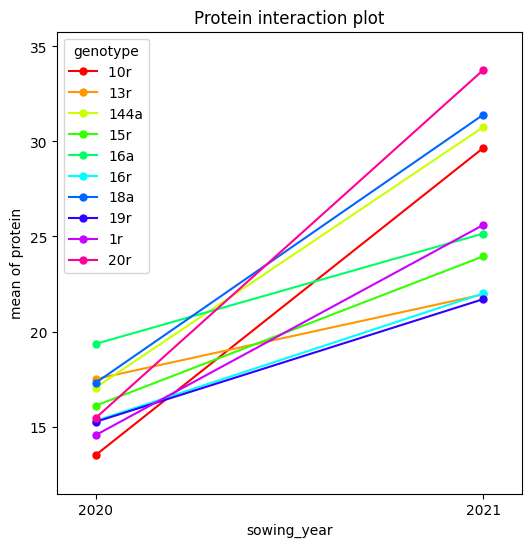

In [95]:
# interaction plot
plt.figure(figsize=(6, 6))
interaction_plot( df['sowing_year'], df['genotype'][0:40], df['protein'],  markersize=10, ax=plt.gca())
plt.title('Protein interaction plot')
plt.xticks(np.unique(df['sowing_year']))
plt.show()

# Principal Component Analysys

In [118]:
# plot pca function
def plot_pca(X_pca, explained_variance):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))

    ax[0] = sns.lineplot(x=np.arange(0, len(explained_variance)), y=explained_variance, ax=ax[0])
    ax[0].set_xlabel('Number PC')
    ax[0].set_ylabel('% variance')
    ax[0].set_title('Explained variance PCA')
    ax[0].grid(0.3)

    cumulative = np.cumsum(explained_variance)
    ax[1] = sns.lineplot(x=np.arange(0, len(explained_variance)), y=cumulative, ax=ax[1])
    ax[1].set_yticks(np.arange(0, 1, 0.05))
    ax[1].set_xticks(range(0, X_pca.shape[1]))
    ax[1].set_xlabel('Number PC')
    ax[1].set_ylabel('% variance')
    ax[1].set_title('Explained variance PCA')
    ax[1].grid(0.3)

    plt.tight_layout()
    plt.show()


df_numerical = df[numerical_features].copy()

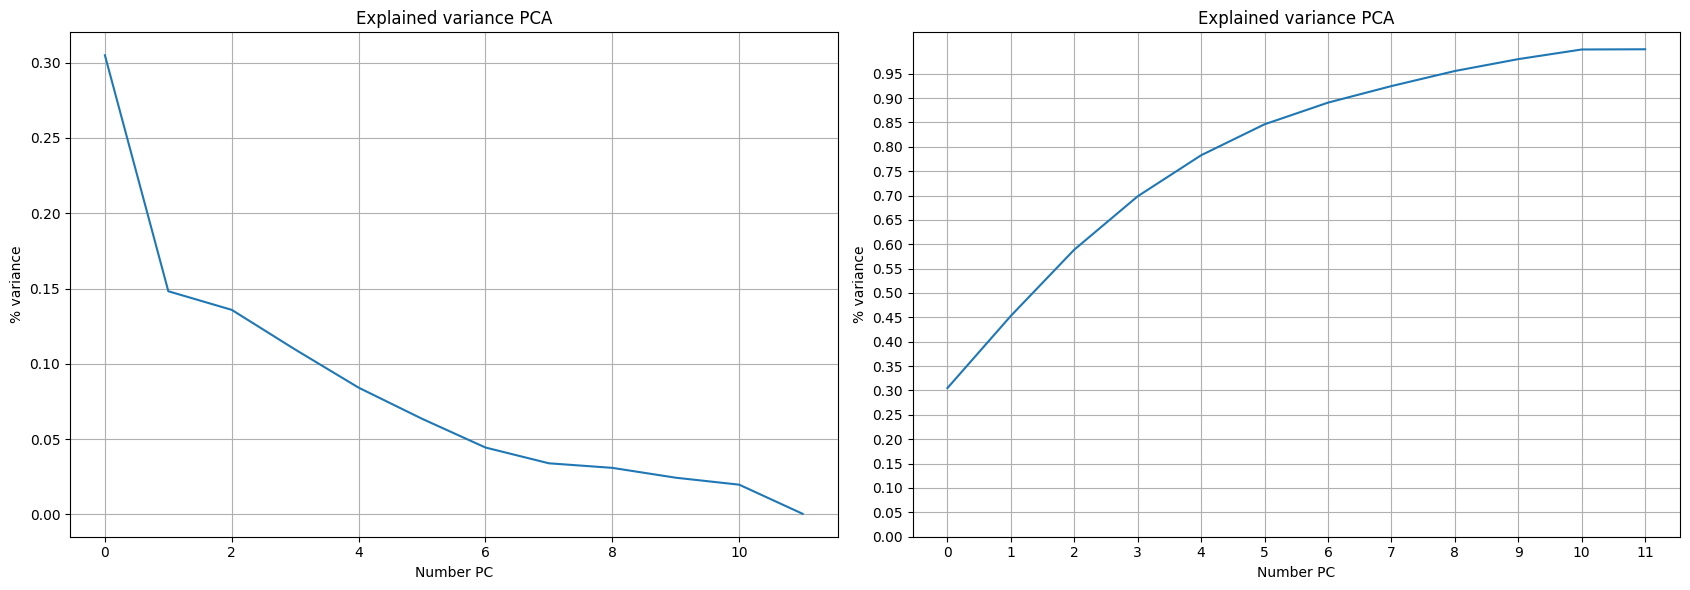

In [210]:
# grouping by genotype
df_grouped = df.drop(['rep', 'block'], axis=1).groupby(['genotype'],
                                                       as_index=False)\
                                                        .mean(numerical_features)

# preprocess with PCA
pipe_pca = Pipeline([('scalar', StandardScaler()),
                    ('pca', PCA(random_state=42))
                    ])

pipe_pca.fit(df_grouped[numerical_features])

X_pca = pipe_pca.transform(df_grouped[numerical_features])
explained_variance = pipe_pca['pca'].explained_variance_ratio_

plot_pca(X_pca, explained_variance)

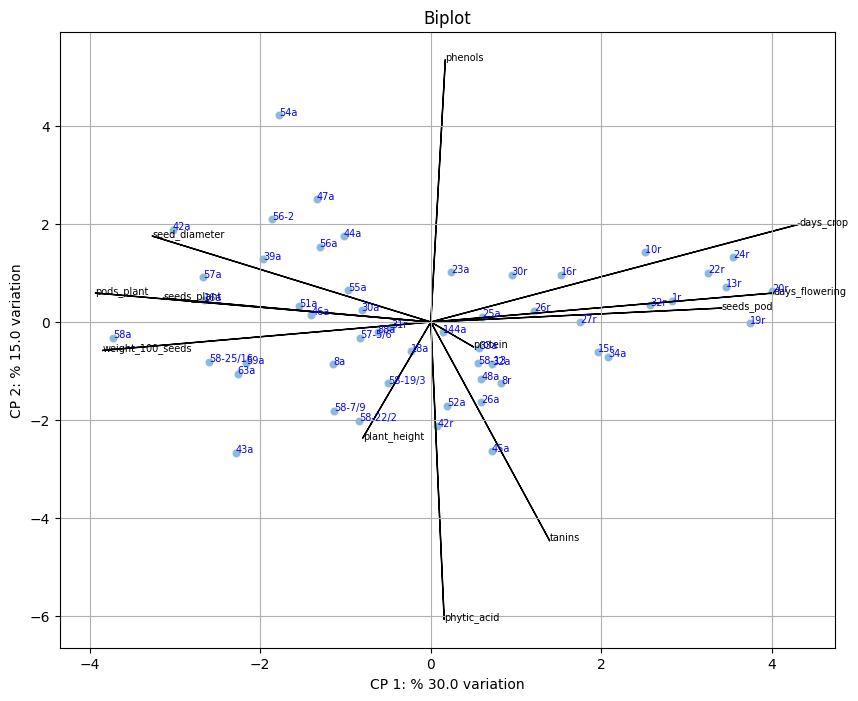

In [211]:
# biplot
def biplot_pca(original_df, X_pca, model, components=(0, 1), arrows=True, hue=None, labels=False):
    """
    make a PCA biplot
    Args:
        original_df (df matrix): df with no scaling/PCA
        X_pca (X matrix)
        model (pca model)
        components (tuple): components to plot, default PC0 and PC1
        arrows (bool, optional): if True: plot arrows
        labels (bool, optional): if True: plot labels
        hue (1d array)
    """
    features_pc = model.components_.T
    explained_variance = model.explained_variance_ratio_
    fig, ax = plt.subplots(figsize=(10, 8))
    if hue is not None:
        ax = sns.scatterplot(x=X_pca[:, components[0]], y=X_pca[:, components[1]], alpha=0.5, ax=ax,
                             hue=hue, size=hue, sizes=(20, 100))
    else:
        ax = sns.scatterplot(x=X_pca[:, components[0]], y=X_pca[:, components[1]], alpha=0.5, ax=ax)
    ax.set_xlabel(f'CP 1: % {round(explained_variance[0], 2)*100} variation')
    ax.set_ylabel(f'CP 2: % {round(explained_variance[1], 2)*100} variation')
    ax.set_title('Biplot')
    ax.grid(0.3)
    if arrows:
        stretching = 10
        for x in range(len(df_numerical.columns)):
                ax.arrow(x=0,
                        y=0,
                        dx=stretching*features_pc[x][0],
                        dy=stretching*features_pc[x][1]
                        )
                ax.text(stretching*features_pc[x][0],
                        stretching*features_pc[x][1],
                        s=df_numerical.columns[x],
                        size=7
                        )
                
    if labels:
        for x in range(len(df_grouped)):
            ax.text(x=X_pca[:, components[0]][x],
                        y=X_pca[:, components[1]][x],
                        s=df_grouped['genotype'][x],
                        size=7,
                        color='blue'
                        )
    plt.show()

biplot_pca(df_grouped, X_pca, pipe_pca['pca'], labels=True)

# hirechichal clustering with PCA and numerical_features

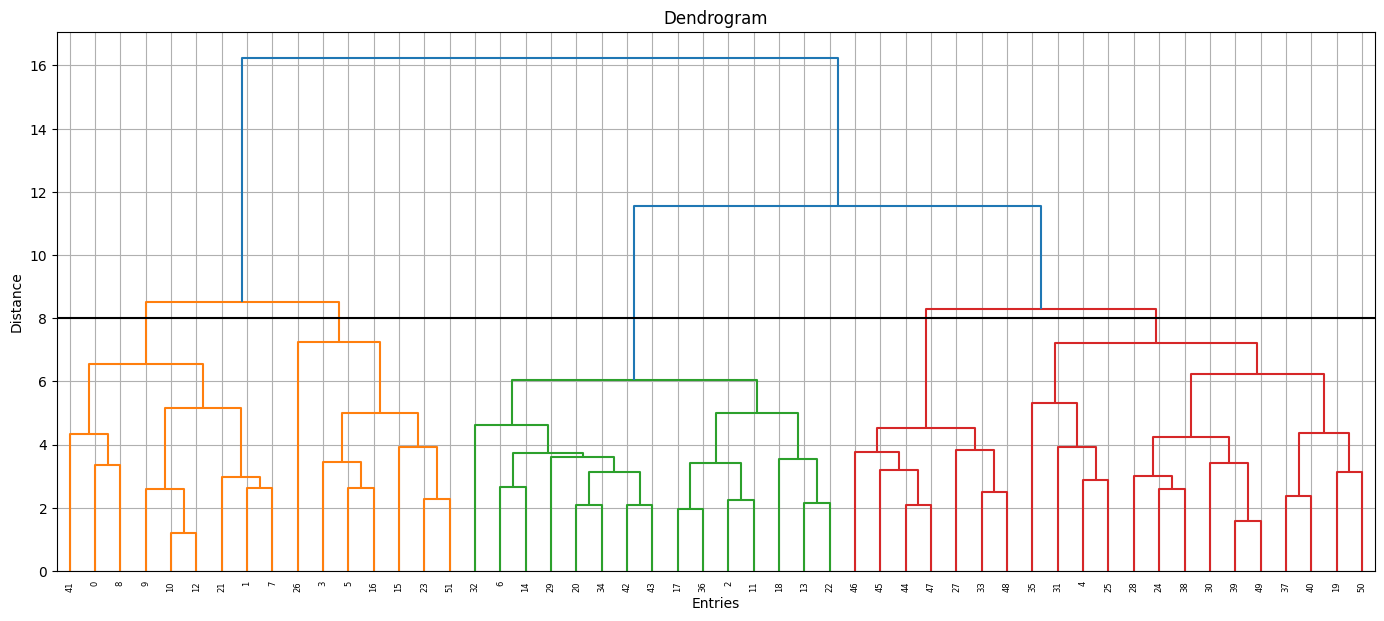

In [251]:
# dendrogram with pca
plt.figure(figsize=(17, 7))
dendro = hierarchy.dendrogram(hierarchy.linkage(X_pca, method='ward')) # ward's criterion minimizes the total variance within clusters
plt.title('Dendrogram')
plt.xlabel('Entries')
plt.ylabel('Distance')
plt.grid(0.3)
plt.axhline(y=8, color='black')
plt.show()

In [247]:
# agglomerative clustering with pca and 5 clusters
agglo_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agglo_clustering.fit(X_pca)
df_grouped['clusters_agglo'] = agglo_clustering.labels_

df_grouped.groupby('clusters_agglo').mean(numerical_features)

,days_flowering,days_crop,plant_height,seeds_pod,pods_plant,seeds_plant,seed_diameter,weight_100_seeds,plants_plot,yield,protein,phytic_acid,phenols,tanins,sowing_year
clusters_agglo,,,,,,,,,,,,,,,
0,91.484375,127.250000,27.156250,1.662500,17.515625,29.609375,4.178594,2.420313,10.0,7.371875,21.281250,1.118750,0.489687,0.4200,2020.5
1,83.059524,117.404762,27.750000,1.278571,37.011905,49.059524,5.394048,3.985714,10.0,20.233333,20.464286,1.052381,0.510238,0.3550,2020.5
2,85.550000,121.033333,28.483333,1.270000,15.316667,19.533333,4.830000,3.920000,10.0,7.798333,21.611667,1.178333,0.481333,0.4475,2020.5


# hirechichal clustering with PCA and molecular data SSR)

In [248]:
# load dataset
molecular = pd.read_csv('../files/phd_ssr.csv')
molecular.head()

,genotype,ssr19_1,ssr19_2,ssr19_3,ssr72_1,ssr72_2,ssr72_3,ssr90_1,ssr90_2,ssr90_3,...,mcu45a_3,ssr179_1,ssr179_2,ssr341_1,ssr341_2,ssr301_1,ssr301_2,ssr240_1,ssr240_2,yield
0,1r,0,1,0,0,0,0,1,0,0,...,1,1,0,0,1,0,1,1,0,6.575
1,10r,0,0,1,0,1,0,0,1,0,...,1,0,1,1,0,1,0,0,1,10.200
2,13r,0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,1,1,0,5.800
3,144a,1,0,0,1,0,0,1,0,0,...,1,1,0,1,0,1,0,0,1,7.200
4,15r,0,1,0,1,0,0,0,0,1,...,0,1,0,0,1,0,1,0,1,5.825


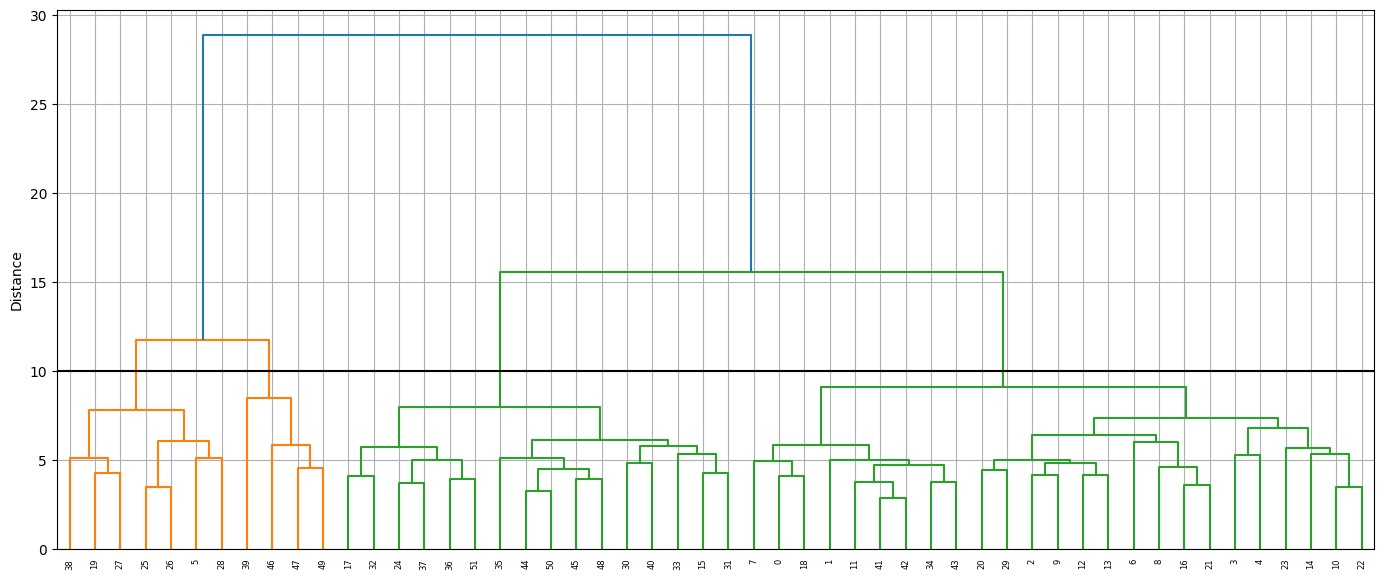

In [286]:
# dendrogram
plt.figure(figsize=(17, 7))
dendro = hierarchy.dendrogram(hierarchy.linkage(molecular.drop('genotype', axis=1), method='complete'))
plt.ylabel('Distance')
plt.grid(0.3)
plt.axhline(y=10, color='black')
plt.show()

In [293]:
# agglomerative clustering with pca and 4 clusters
agglo_clustering = AgglomerativeClustering(n_clusters=4)
agglo_clustering.fit(molecular.drop('genotype', axis=1))
molecular['clusters_agglo'] = agglo_clustering.labels_
molecular.head()

,genotype,ssr19_1,ssr19_2,ssr19_3,ssr72_1,ssr72_2,ssr72_3,ssr90_1,ssr90_2,ssr90_3,...,ssr179_1,ssr179_2,ssr341_1,ssr341_2,ssr301_1,ssr301_2,ssr240_1,ssr240_2,yield,clusters_agglo
0,1r,0,1,0,0,0,0,1,0,0,...,1,0,0,1,0,1,1,0,6.575,0
1,10r,0,0,1,0,1,0,0,1,0,...,0,1,1,0,1,0,0,1,10.200,0
2,13r,0,0,1,0,1,0,0,1,0,...,1,0,0,1,0,1,1,0,5.800,0
3,144a,1,0,0,1,0,0,1,0,0,...,1,0,1,0,1,0,0,1,7.200,0
4,15r,0,1,0,1,0,0,0,0,1,...,1,0,0,1,0,1,0,1,5.825,0


# RandomForestRegressor to predict yield with molecular data

In [313]:
# tts
X = molecular.drop(['genotype', 'yield', 'clusters_agglo'], axis=1).copy()
y = molecular['yield'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KFolds definition
skf = KFold(n_splits=5, shuffle=True, random_state=42)

In [336]:
# GridSearchCV RFC
rfr = RandomForestRegressor(n_jobs=-1,  random_state=42)

# param_grid
param_grid = {
            'n_estimators': [x for x in range(80, 120, 1)],
            'criterion': ['squared_error'],
            'max_depth': [x for x in range(2, 30, 1)],
            'min_samples_split': [x for x in range(50, 90, 1)],
            'bootstrap': [True, False]
            }

grid_rfr = RandomizedSearchCV(estimator=rfr,
                            param_distributions=param_grid,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,
                            cv=skf,
                            return_train_score=True
                            )

grid_rfr.fit(X_train, y_train)

df_rfr = pd.DataFrame(grid_rfr.cv_results_)

# prints
print(f'best_params_: {grid_rfr.best_params_}')
print(f'train_score: {df_rfr.loc[df_rfr["rank_test_score"]==1, "mean_train_score"].values[0]}')
print(f'best_test_score: {grid_rfr.best_score_}')

best_params_: {'n_estimators': 90, 'min_samples_split': 74, 'max_depth': 16, 'criterion': 'squared_error', 'bootstrap': False}
train_score: -7.59162103708711
best_test_score: -7.650544618654027
